In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin
import scvi
import os
import scanpy as sc
sc.settings.figdir=os.path.expanduser('~/WbFigures/RetinaAnalysis')


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


In [2]:
model_tag='1.9.1.8.5_Retina_final_noQ_INP'
model_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
batch_key='batch'
discov_key='species'
layer_key='UMIs'


In [3]:
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.5_Retina_final_noQ_INP/p3_adata.h5ad'),backed='r')
adata.uns['species_colors']=['blue','red','green','yellow','orange','cyan','magenta','teal','goldenrod','purple','maroon','pink','violet','black','grey','beige']

# species_aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key],layer=layer_key,normalize=True)
# species_real_means=torch.tensor(species_aggr_means[0],requires_grad=False)
# species_log_real_means=safe_log_transform(species_aggr_means[0]) # #species,#cluster,#genes array

In [4]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer=layer_key,
    batch_key=batch_key,
    categorical_covariate_keys=[discov_key],
)
model = scvi.model.SCVI(adata, 
                        dispersion="gene-batch", 
                        n_hidden=128, 
                        n_latent=64, 
                        n_layers=3)
model.train(max_epochs=100)

## Save model
model.save(dir_path="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/RetinaMammalsSCVI",overwrite=True)

## Extract integrated space
adata.obsm["X_scVI"] = model.get_latent_representation()

import cuml
umap = cuml.UMAP(n_neighbors = 40,min_dist=0.2,spread=1,metric='manhattan')
adata.obsm["X_umap_scVI"] =umap.fit_transform(adata.obsm['X_scVI'])


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/matthew.schmitz/Matthew/utils/miniforge3/e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/matthew.schmitz/Matthew/utils/miniforge3/e ...
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `t

Epoch 100/100: 100%|██████████| 100/100 [1:57:31<00:00, 68.68s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.7e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [1:57:31<00:00, 70.52s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.7e+3]


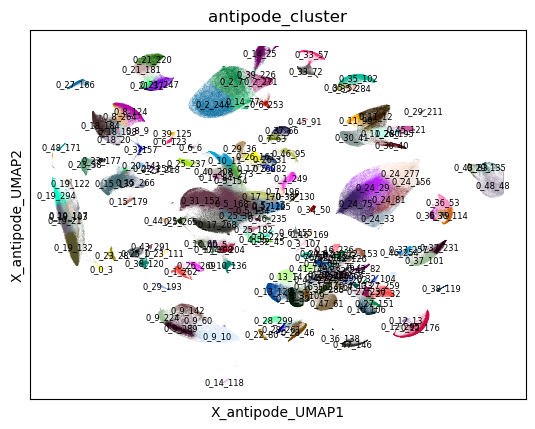

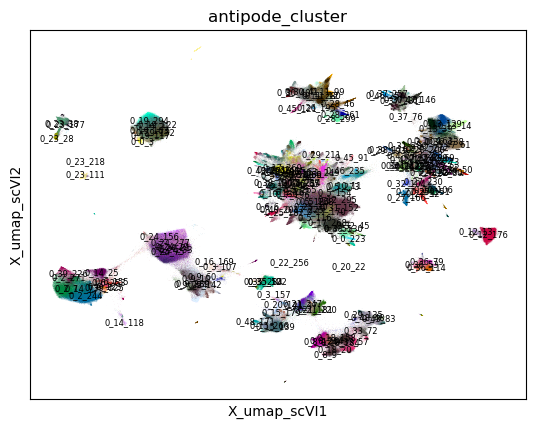

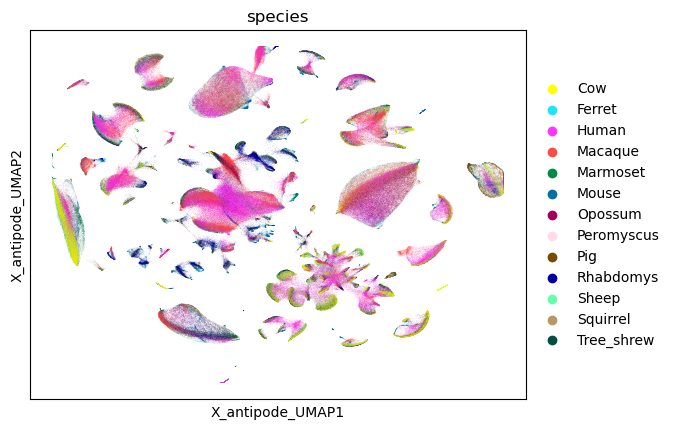

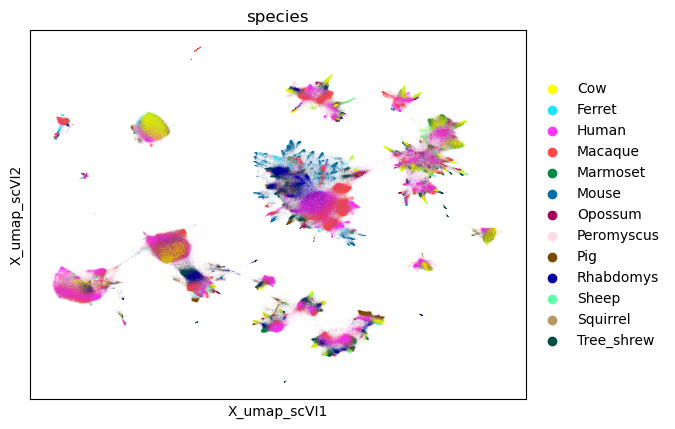

In [5]:
sc.pl.embedding(
    adata,
    basis='X_antipode_UMAP',
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102,save='antipode_cluster.pdf'
)
sc.pl.embedding(
    adata,
    basis="X_umap_scVI",
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102,save='antipode_cluster.pdf'
)

sc.pl.embedding(
    adata,
    basis='X_antipode_UMAP',
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key],save=f'{discov_key}.pdf'
)
sc.pl.embedding(
    adata,
    basis="X_umap_scVI",
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key],save=f'{discov_key}.pdf'
)

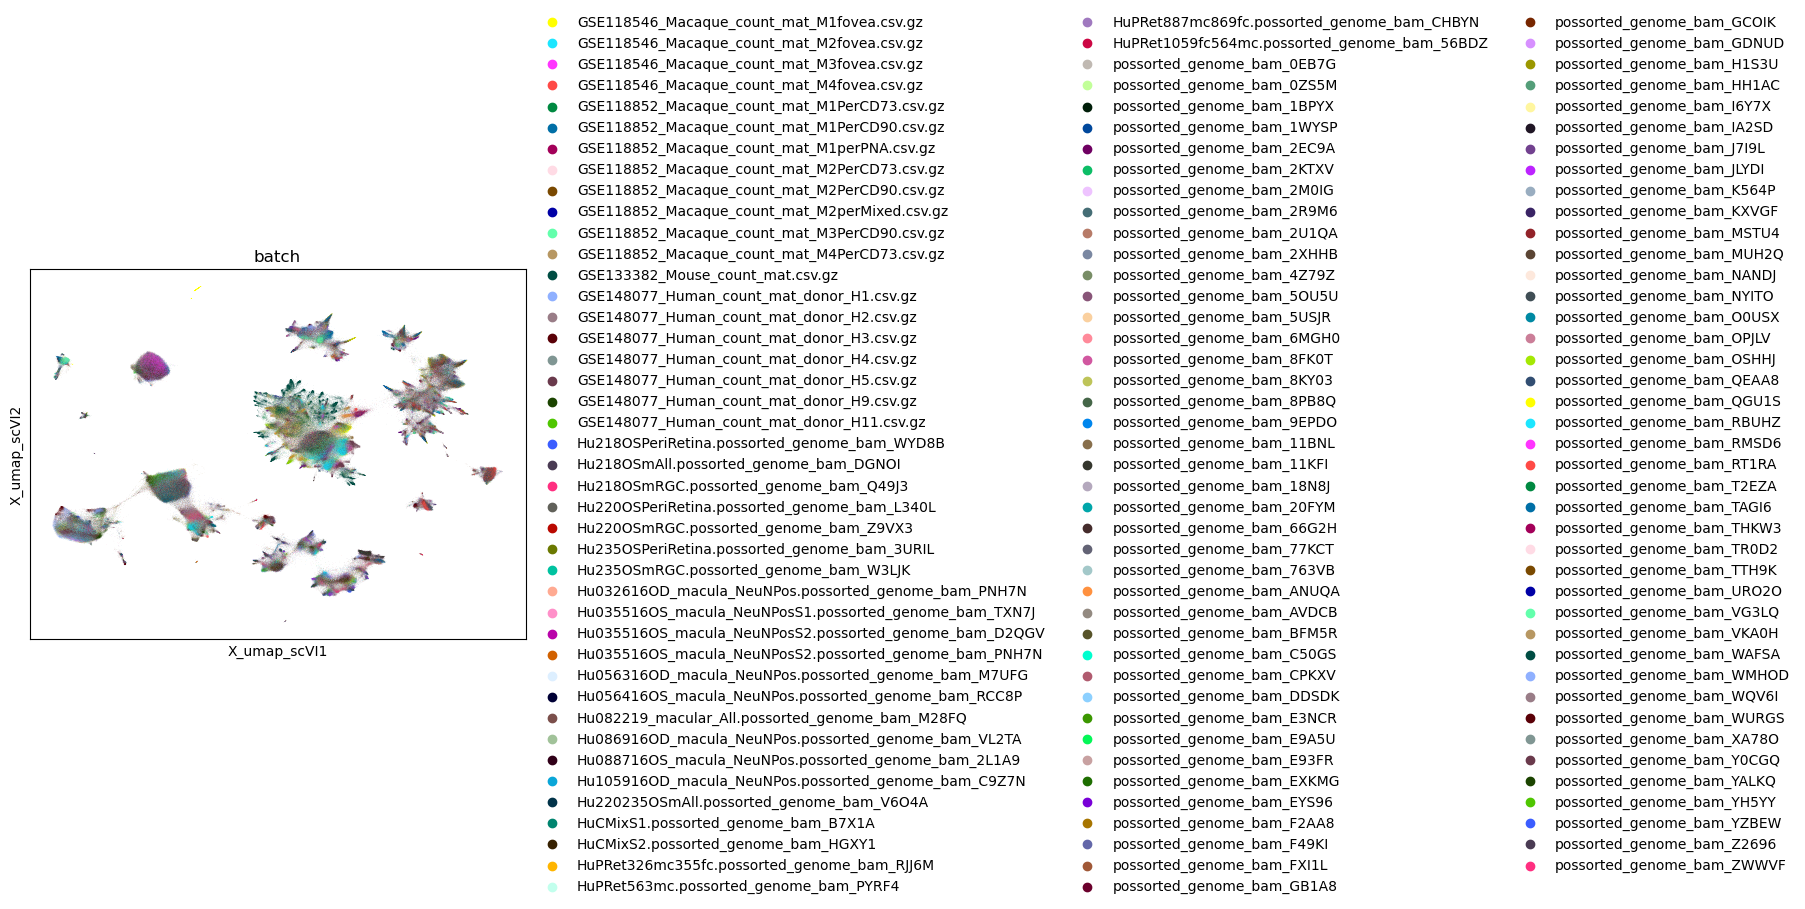

In [8]:
sc.pl.embedding(
    adata,
    basis="X_umap_scVI",
    palette=sc.pl.palettes.godsnot_102,
    color=[batch_key],save=f'{batch_key}.pdf'
)

In [6]:
# adata.write_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.5_Retina_final_noQ_INP/analysis_inprogress.h5ad')

In [7]:
np.savetxt(os.path.join(model_path,f"X_scVI.csv"), adata.obsm['X_scVI'], delimiter=",")
np.savetxt(f"/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/RetinaIntegrations/X_scVI.csv", adata.obsm['X_scVI'], delimiter=",")
np.savetxt(os.path.join(model_path,f"X_umap_scVI.csv"), adata.obsm['X_umap_scVI'], delimiter=",")
